In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mticker
import math

## Part 1: Load and explore


### 1. Load the dataset and display the first few rows.

In [4]:
# loading the dataset and displayed a couple rows
movies = pd.read_csv("../data/movies.csv")
movies.head(2)

,Title,Year,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Nominee,Winner,Genre_Action,...,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science Fiction,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western
0,#Alive,2020,7.228,1956,6300000,13416285,614696,0,0,True,...,False,True,False,False,False,True,False,False,False,False
1,10 Cloverfield Lane,2016,6.994,8359,15000000,110216998,333371,0,0,False,...,False,True,False,False,False,True,False,True,False,False


### 2. How many movies in the dataset were nominated for Best Picture?

In [6]:
print(f"There were {movies["Nominee"].count()} movies nominated for Best Picture.")

There were 1005 movies nominated for Best Picture.


### 3. What percentage of movies were nominated?

In [8]:
movies["Nominee"].value_counts(normalize=True).reset_index()

,Nominee,proportion
0,0,0.909453
1,1,0.090547


### 4. Compute the average revenue for:

#### Nominated Movies, non-nominated movies - Does revenue look associated with nominations?

In [11]:
avg_nom_rev = movies.groupby("Nominee")['Revenue'].mean().astype('int64').reset_index()
avg_nom_rev

,Nominee,Revenue
0,0,189624332
1,1,232573777


In [12]:
print(f"The average revenue for a nominated movie is ${avg_nom_rev["Revenue"][1]:,.2f} whereas the \n average revenue for a non-nominated movie is ${avg_nom_rev["Revenue"][0]:,.2f}")

The average revenue for a nominated movie is $232,573,777.00 whereas the 
 average revenue for a non-nominated movie is $189,624,332.00


Yes, based on the fact that revenue on average is higher for nominated movies than for non nominated movies, revenue does look like it's associated with nominations.

## Part 2: Logistic Regression: Revenue Only


### 5. Fit a logistic regression model for whether a movie was nominated based on its revenue.

In [16]:
m_nom_rev_logreg = smf.logit("Nominee ~ Revenue",
                          data = movies).fit()

Optimization terminated successfully.
         Current function value: 0.303106
         Iterations 6


In [17]:
m_nom_rev_logreg.params#.astype('int64')

Intercept   -2.385659e+00
Revenue      3.752031e-10
dtype: float64

In [18]:
#np.exp(m_nom_rev_logreg.params["Revenue"])

In [19]:
m_nom_rev_logreg.params["Revenue"]

3.752031436239548e-10

### 6. Interpret the sign of the coefficient for Revenue.

The coefficient is 3.752031e-10. For every unit of, revenue increases by 3.752031e-10. 

In [22]:
print(f"The probability of a movie being nominated (Nominee = 1) = equals \n the logistic of (the intercept of -2.38565 + 3.752031 * (Revenue))")

The probability of a movie being nominated (Nominee = 1) = equals 
 the logistic of (the intercept of -2.38565 + 3.752031 * (Revenue))


### 7. Use the model to estimate the probability of nomination for a movie with $10M revenue, $$\$100M revenue, and $\$500M revenue. 

In [24]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [25]:
Revenue_10M = 10000000

logreg_prop_10 = m_nom_rev_logreg.params['Intercept'] + m_nom_rev_logreg.params['Revenue']*Revenue_10M

print(f'Estimated probability of making $10,000,000 in revenue is {logistic(logreg_prop_10):,.6f}.')

Estimated probability of making $10,000,000 in revenue is 0.084563.


In [26]:
Revenue_100M = 100000000

logreg_prop_100 = m_nom_rev_logreg.params['Intercept'] + m_nom_rev_logreg.params['Revenue']*Revenue_100M

print(f'Estimated probability of making $10,000,000 in revenue is {logistic(logreg_prop_100):,.6f}.')

Estimated probability of making $10,000,000 in revenue is 0.087214.


In [27]:
Revenue_500M = 500000000

logreg_prop_500 = m_nom_rev_logreg.params['Intercept'] + m_nom_rev_logreg.params['Revenue']*Revenue_500M

print(f'Estimated probability of making $10,000,000 in revenue is {logistic(logreg_prop_500):,.6f}.')

Estimated probability of making $10,000,000 in revenue is 0.099925.


### 8. Make a plot of predicted probability vs. revenue.

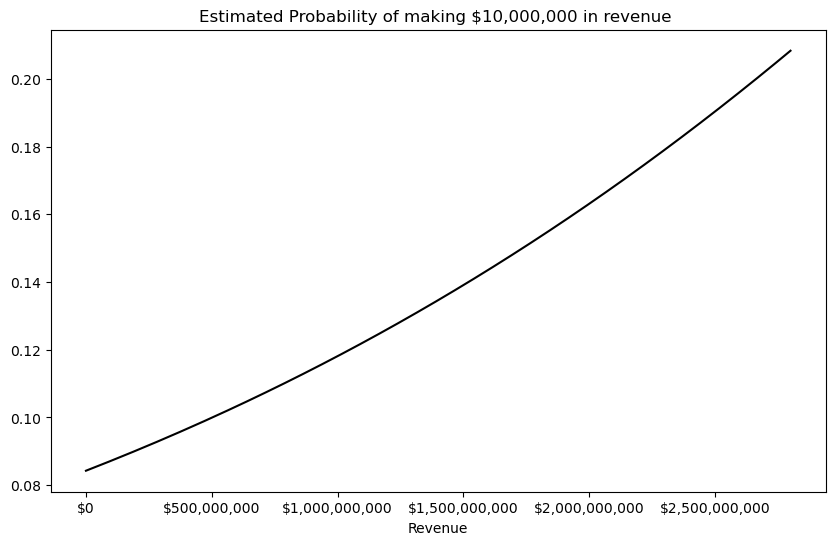

In [29]:
m_fit_df = pd.DataFrame({
    'Revenue': np.linspace(start = movies['Revenue'].min(),
                            stop = movies['Revenue'].max(),
                            num = 150)
})

m_fit_df['fit'] = m_nom_rev_logreg.predict(m_fit_df)

ax = m_fit_df.plot(x = 'Revenue',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of making $10,000,000 in revenue ')

formatter = mticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(formatter);

In [30]:
movies_summary = (
    movies
    .assign(group = pd.qcut(movies['Revenue'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Revenue', 'Nominee']]
    .mean()
    .reset_index()
    .rename(columns = {'Nominee': 'eprob'})
)
movies_summary['fit_probability'] = m_nom_rev_logreg.predict(movies_summary[['Revenue']])
movies_summary

,group,Revenue,eprob,fit_probability
0,"(-0.001, 1444389.0]",8.789764e+04,0.049751,0.084275
1,"(1444389.0, 21107167.4]",1.076188e+07,0.089109,0.084585
2,"(21107167.4, 42412175.6]",3.167992e+07,0.120000,0.085195
3,"(42412175.6, 73900000.0]",5.607996e+07,0.118812,0.085911
4,"(73900000.0, 119688968.6]",9.390313e+07,0.110000,0.087032
5,"(119688968.6, 180593261.2]",1.489283e+08,0.100000,0.088686
6,"(180593261.2, 297930179.2]",2.301296e+08,0.079208,0.091180
7,"(297930179.2, 525616873.2]",3.964409e+08,0.070000,0.096484
8,"(525616873.2, 2799439100.0]",9.640975e+08,0.118812,0.116714


In [31]:
movies_summary_20 = (
    movies
    .assign(group = pd.qcut(movies['Revenue'], 
                            q = 20, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Revenue', 'Nominee']]
    .mean()
    .reset_index()
    .rename(columns = {'Nominee': 'eprob'})
)
movies_summary['fit_probability'] = m_nom_rev_logreg.predict(movies_summary[['Revenue']])
movies_summary

,group,Revenue,eprob,fit_probability
0,"(-0.001, 1444389.0]",8.789764e+04,0.049751,0.084275
1,"(1444389.0, 21107167.4]",1.076188e+07,0.089109,0.084585
2,"(21107167.4, 42412175.6]",3.167992e+07,0.120000,0.085195
3,"(42412175.6, 73900000.0]",5.607996e+07,0.118812,0.085911
4,"(73900000.0, 119688968.6]",9.390313e+07,0.110000,0.087032
5,"(119688968.6, 180593261.2]",1.489283e+08,0.100000,0.088686
6,"(180593261.2, 297930179.2]",2.301296e+08,0.079208,0.091180
7,"(297930179.2, 525616873.2]",3.964409e+08,0.070000,0.096484
8,"(525616873.2, 2799439100.0]",9.640975e+08,0.118812,0.116714


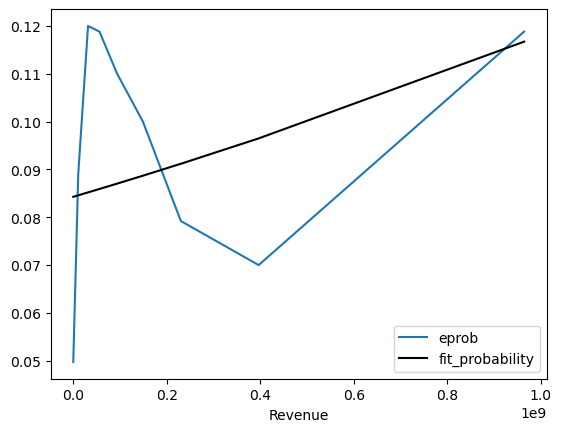

In [32]:
ax = movies_summary.plot(x = 'Revenue', y = 'eprob')
movies_summary.plot(x = 'Revenue', y = 'fit_probability',
                color = 'black',
                ax = ax);

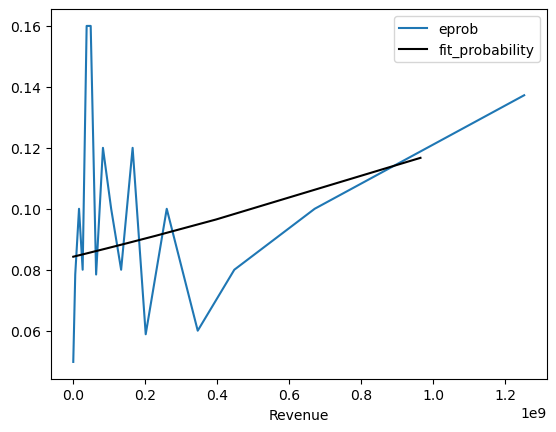

In [33]:
ax = movies_summary_20.plot(x = 'Revenue', y = 'eprob')
movies_summary.plot(x = 'Revenue', y = 'fit_probability',
                color = 'black',
                ax = ax);

## Part 3: Add Genre

### 9. Fit a model for whether a movie was nominated based on its revenue and whether or not it is a drama.

In [36]:
m_nom_rev_drama_logreg = smf.logit("Nominee ~ Revenue + Genre_Drama",
                          data = movies).fit()

Optimization terminated successfully.
         Current function value: 0.234564
         Iterations 8


In [37]:
m_nom_rev_drama_logreg.params#.round()#.astype('int64')#.round() 

Intercept             -4.783568e+00
Genre_Drama[T.True]    3.340881e+00
Revenue                1.727152e-09
dtype: float64

### 10. Interpret the coefficient for Genre_Drama.

In [97]:
f"The probability of a movie being nominated (Nominee = 1) = \n equals the logistic of (the intercept of -2.38565 + 3.752031 * (Revenue))"

'The probability of a movie being nominated (Nominee = 1) = \n equals the logistic of (the intercept of -2.38565 + 3.752031 * (Revenue))'

In [39]:
#m_nom_rev_drama_logreg.params["Genre_Drama[T.True]"]

In [40]:
#m_nom_rev_drama_logreg.params["Revenue"]

In [41]:
#m_nom_rev_drama_logreg.pvalues["Revenue"]

In [42]:
#m_nom_rev_drama_logreg.pvalues["Genre_Drama[T.True]"].astype

In [44]:
#np.exp(m_nom_rev_drama_logreg.params["Genre_Drama[T.True]"])

In [45]:
#np.exp(m_nom_rev_drama_logreg.params["Revenue"])

In [46]:
#np.array().astype('int64') 

### 11. Using your final model, compute the predicted probabilities of nominations for: $\$20M non-drama, $\$20M drama, $$\$300M non-drama, #\$300M drama

In [113]:
m_nom_ndrama_logreg = smf.logit("Nominee ~ Genre_Drama",
                          data = movies).fit()

Optimization terminated successfully.
         Current function value: 0.244456
         Iterations 8


In [115]:
m_nom_ndrama_logreg.params#.astype('int64')

Intercept             -4.058874
Genre_Drama[T.True]    2.816884
dtype: float64

### \$20M non-drama

In [147]:
NonDrama = 0
M20 = 20000000

logreg_prop_ND = m_nom_rev_drama_logreg.params['Intercept'] + m_nom_rev_drama_logreg.params["Revenue"]*M20 + m_nom_rev_drama_logreg.params['Genre_Drama[T.True]']*NonDrama

print(f'Estimated probability of a movie being nominated when it is not a drama is {logistic(logreg_prop_ND):,.6f}.')

Estimated probability of a movie being nominated when it is not a drama is 0.008586.


### \$20M drama

In [150]:
Drama = 1
M20 = 20000000

logreg_prop_ND = m_nom_rev_drama_logreg.params['Intercept'] + m_nom_rev_drama_logreg.params["Revenue"]*M20 + m_nom_rev_drama_logreg.params['Genre_Drama[T.True]']*Drama

print(f'Estimated probability of a movie being nominated when it is not a drama is {logistic(logreg_prop_ND):,.6f}.')

Estimated probability of a movie being nominated when it is not a drama is 0.196527.


### \$300M Non-Drama

In [ ]:
NonDrama = 0
M20 = 20000000

logreg_prop_ND = m_nom_rev_drama_logreg.params['Intercept'] + m_nom_rev_drama_logreg.params["Revenue"]*M20 + m_nom_rev_drama_logreg.params['Genre_Drama[T.True]']*NonDrama

print(f'Estimated probability of a movie being nominated when it is not a drama is {logistic(logreg_prop_ND):,.6f}.')

### 12. Which variable has the larger effect: being a drama or revenue?

12 how many dollars difference would there be from going from non drama to drama